<a href="https://colab.research.google.com/github/MateoRivera/network-dynamics/blob/main/H3/H3_Alejandro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.1.3  Epidemic simulation with vaccination

## 1.2 Simulate a pandemic without vaccination

In [13]:
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import progressbar

sns.set()

# Parameters
n = 500
k = 6
beta = 0.25
rho = 0.6
week_to_simulate = 15
n_simulations = 100
initial_infected_nodes = np.random.choice(range(n), 10)


# Function to generate a preferential attachment graph
# Function to generate a preferential attachment graph
def preferential_attachment_graph(n, k):
    assert n > k + 1, "Number of nodes (n) must be greater than k + 1."

    # Initial complete graph with k + 1 nodes
    G = nx.complete_graph(k + 1)
    add_edges = [k // 2, (k + 1) // 2]

    # At every time t>=2 create a new graph by adding a new node
    for t in range(k + 2, n):
        G.add_node( t-1) #t-1 to prevent a jump in node name enumeration n={4,5,6,___,8,9}

        # Calculate the degree of each existing node, serve as wi(t-1)
        degrees = dict(G.degree())

        # Select nodes to connect based on preferential attachment
        targets = set()

        # Alternate edge count for odd k
        num_edges = add_edges[(t - (k + 2)) % 2] if k % 2 else k // 2  # Fix to add k/2 edges per new node

        # Loop to ensure no redundant edges to the same target
        while len(targets) < num_edges:
            # Probability of connecting to an existing node is proportional to its current degree wi(t-1)
            chosen = random.choices(
                population=list(degrees.keys()),
                weights=list(degrees.values()),
                k=1
            )[0]
            if chosen != (t - 1):  # Avoid self-loops
                targets.add(chosen)

        # Add edges between the new node and selected targets
        for target in targets:
            G.add_edge(t, target)

    return G



def get_infected_neighbors(G, i):
    """
    Function to get infected  and not vaccinated neighbors of a node
    """
    return list(filter(lambda neighbor: G.nodes[neighbor]['state'] == 'I' and G.nodes[neighbor]['vaccinated'] == 0, G.neighbors(i)))

def sample_individuals(size):
    numbers = list(range(500))
    random.shuffle(numbers) #random shuffle the list

    while numbers:  # while theres available numbers
        yield numbers[:size]  # return a sample
        del numbers[:size]  # delete the sampled numbers

def vaccinate_individuals(G, k):
    """
    Function to set a node as vaccinated
    """

    sampled_nodes = next(sample_individuals(k))
    for node in sampled_nodes:
        G.nodes[node]['vaccinated'] = 1



# Function to calculate infection/recovery probability
def P(G, i, beta=None, rho=None):
    infected_neighbors = get_infected_neighbors(G, i)
    if beta is not None:
        return 1 - (1 - beta) ** len(infected_neighbors)  # Infection probability
    elif rho is not None:
        return rho  # Recovery probability
    return 0

def EpidemicSimulation(G, beta, rho, time_limit):
    states = ['S', 'I', 'R']
    vacc_t = [0,5,15,25,35,45,55,60,60,60,60,60,60,60,60,60] #total
    # We do not want to modify the original graph
    G = G.copy()
    new_vacc_nodes=[0]
    # nodes_infected saves is a matrix of G.number_of_nodes() X time_limit
    # each row is associated to a node and each column to the state of the node
    #nodes_infected = np.zeros((G.number_of_nodes(), 1))

    nodes_infected = np.reshape([states.index(G.nodes[i]['state']) for i in G.nodes], (-1, 1))


    # New infected
    new_nodes_infected = [nodes_infected.sum()]

    # Warning: G.nodes[i]['state'] saves the current state, not historical data
    for t in range(1, time_limit + 1):
        # We will be modifying the states of G, so we need a copy of the iteration t - 1
        G_copy = G.copy()
        current_nodes_infected = np.copy(nodes_infected[:, -1])
        new_nodes_infected.append(0)
        vacc_sample = (vacc_t[t]-vacc_t[t-1])*5 #percentage of people to vaccinate
        new_vacc_nodes.append(sum(new_vacc_nodes)+vacc_sample if vacc_sample!=0 else  new_vacc_nodes[-1])
        vaccinate_individuals(G_copy, vacc_sample)
        # Let's make some transitions depending on the probabilities
        for i in G_copy.nodes:
            new_state = G_copy.nodes[i]['state']
            vaccinated = G_copy.nodes[i]['vaccinated']
            if new_state == 'S':
                # 1 if i got infected, 0 otherwise
                if not vaccinated:
                    i_is_infected = np.random.binomial(1, P(G_copy, i, beta = beta))
                else:
                    i_is_infected = 0

                if i_is_infected:
                    new_state = 'I'
                    new_nodes_infected[-1] += 1
                elif vaccinated:
                    new_state = 'R'

            elif new_state == 'I':
                # 1 if i get recovered, 0 otherwise
                i_is_recovered = np.random.binomial(1, P(G_copy, i, rho = rho))

                if i_is_recovered:
                    new_state = 'R'

            # Let's update the state of the node
            G.nodes[i]['state'] = new_state
            current_nodes_infected[i] = states.index(new_state)

        nodes_infected = np.append(nodes_infected, current_nodes_infected.reshape(-1, 1), axis=1)

    return nodes_infected, new_nodes_infected, new_vacc_nodes



# Function for running multiple simulations
def Simulations(G, beta, rho, time_limit = 15, n_simulations = 100, use_progressbar=True):
    simulations = []
    if use_progressbar:
        bar = progressbar.ProgressBar(max_value=n_simulations)

    for s in range(n_simulations):
        simulations.append(EpidemicSimulation(G, beta, rho, time_limit))
        if use_progressbar:
            bar.update(s+1)

    if use_progressbar:
        bar.finish()

    return simulations




In [14]:
# Generate graph
G = preferential_attachment_graph(n, k)


# Set initial state for nodes
for node in initial_infected_nodes:
    G.nodes[node]['state'] = 'I'
    G.nodes[node]['vaccinated'] = 0 #At week 0 nobody is vaccinated

for node in G.nodes():
    if node not in initial_infected_nodes:
        G.nodes[node]['state'] = 'S'  # Default state for non-infected nodes
    G.nodes[node]['vaccinated'] = 0 #At week 0 nobody is vaccinated

# Run simulations
S = Simulations(G, beta, rho, time_limit = week_to_simulate, n_simulations=n_simulations)

# Calculate the average number of new infected nodes
average_new_nodes_infected = np.mean([simulation[1] for simulation in S], axis=0)



100% (100 of 100) |######################| Elapsed Time: 0:00:10 Time:  0:00:10


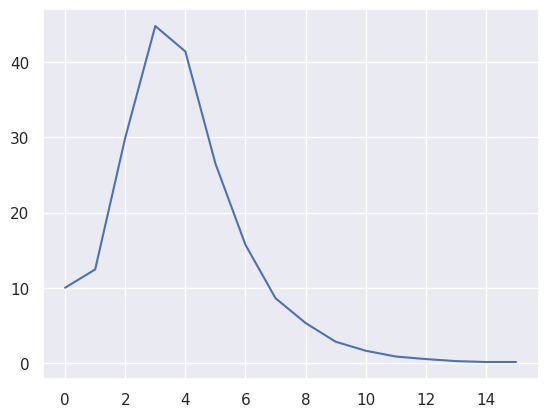

In [15]:

plt.plot(average_new_nodes_infected)

[[4.9000e+02 4.5301e+02 3.7771e+02 2.9530e+02 2.2483e+02 1.7629e+02
  1.4279e+02 1.2691e+02 1.2161e+02 1.1880e+02 1.1719e+02 1.1635e+02
  1.1585e+02 1.1562e+02 1.1551e+02 1.1540e+02]
 [1.0000e+01 1.6720e+01 3.6490e+01 5.9800e+01 6.5510e+01 5.2700e+01
  3.6730e+01 2.3340e+01 1.4910e+01 8.8400e+00 5.2800e+00 3.0300e+00
  1.7200e+00 8.3000e-01 4.9000e-01 3.1000e-01]
 [0.0000e+00 3.0270e+01 8.5800e+01 1.4490e+02 2.0966e+02 2.7101e+02
  3.2048e+02 3.4975e+02 3.6348e+02 3.7236e+02 3.7753e+02 3.8062e+02
  3.8243e+02 3.8355e+02 3.8400e+02 3.8429e+02]]


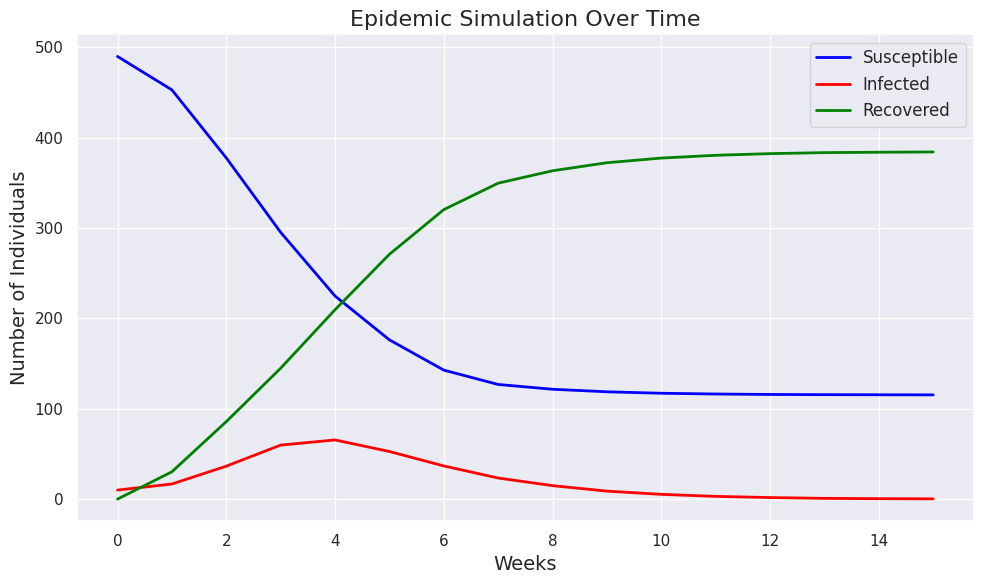

In [16]:
# Extract and calculate the total number of S, I, and R nodes for each week
def calculate_average_states(simulations):
    time_limit = len(simulations[0][1])
    total_states = np.zeros((3, time_limit))  # For S, I, R
    for simulation in simulations: # Simulation has a tuple of matrix with 500 rows and 15 columns and a vector with the new infected
        states = simulation[0]  # Get the state history for each node
        for t in range(states.shape[1]): # states.shape[1] returns the number of weeks of the simulation
            # summing the number of S,I,R by each week
            total_states[0, t] += np.sum(states[:, t] == 0)  # Susceptible (S)
            total_states[1, t] += np.sum(states[:, t] == 1)  # Infected (I)
            total_states[2, t] += np.sum(states[:, t] == 2)  # Recovered (R)


    # Calculate the average across all simulations
    average_states = total_states / len(simulations) # we divide by the number of simulations length (simulations)
    return average_states

# Calculate the average states for S, I, R
average_states = calculate_average_states(S)
print (average_states)
# Plotting the results
time = range(week_to_simulate + 1)
plt.figure(figsize=(10, 6))

plt.plot(time, average_states[0], label='Susceptible', color='blue', linewidth=2)
plt.plot(time, average_states[1], label='Infected', color='red', linewidth=2)
plt.plot(time, average_states[2], label='Recovered', color='green', linewidth=2)

plt.title("Epidemic Simulation Over Time", fontsize=16)
plt.xlabel("Weeks", fontsize=14)
plt.ylabel("Number of Individuals", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

plt.show()

In [21]:
_,b,_ = average_states

In [22]:
b

array([10.  , 16.72, 36.49, 59.8 , 65.51, 52.7 , 36.73, 23.34, 14.91,
        8.84,  5.28,  3.03,  1.72,  0.83,  0.49,  0.31])

# 1.4

In [ ]:
def MRSE(I):
    I = np.array(I)
    I_0 = np.array([1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0], dtype=float)
    return np.sqrt(np.mean((I - I_0) ** 2))


In [ ]:
def get_graph(n,k):
    G = preferential_attachment_graph(n, k)
    # Set initial state for nodes
    for node in initial_infected_nodes:
        G.nodes[node]['state'] = 'I'
        G.nodes[node]['vaccinated'] = 0 #At week 0 nobody is vaccinated

    for node in G.nodes():
        if node not in initial_infected_nodes:
            G.nodes[node]['state'] = 'S'  # Default state for non-infected nodes
        G.nodes[node]['vaccinated'] = 0 #At week 0 nobody is vaccinated
    return G


In [25]:
def gradient_descent( iterations = 1000, learning_rate = 0.0001,
                     stopping_threshold = 1e-6):

    # Initializing weight, bias, learning rate and iterations
    n = 934
    k = 10
    beta = 0.3
    rho = 0.6

    delta_k = 1
    delta_beta = 0.1
    delta_rho = 0.1

    week_to_simulate = 15
    n_simulations = 10
    initial_infected_nodes = np.random.choice(range(n), 10)

    current_weight = 0.1
    current_bias = 0.01
    iterations = iterations
    learning_rate = learning_rate
    n = float(len(x))

    ks = []
    betas = []
    rhos = []
    costs = []
    previous_cost = None


    # Estimation of optimal parameters
    for i in range(iterations):

        S = Simulations(get_graph(n,k), beta, rho, time_limit = week_to_simulate, n_simulations=n_simulations)
        I_predicted = np.mean([simulation[1] for simulation in S], axis=0)

        #Run Simulations
        S_k1 = Simulations(get_graph(n,k+delta_k), beta, rho, time_limit = week_to_simulate, n_simulations=n_simulations)
        S_k2 = Simulations(get_graph(n,k-delta_k), beta, rho, time_limit = week_to_simulate, n_simulations=n_simulations)
        S_b1 = Simulations(get_graph(n,k), beta+delta_beta, rho, time_limit = week_to_simulate, n_simulations=n_simulations)
        S_b2 = Simulations(get_graph(n,k), beta-delta_beta, rho, time_limit = week_to_simulate, n_simulations=n_simulations)
        S_rho1= Simulations(get_graph(n,k), beta, rho+delta_rho, time_limit = week_to_simulate, n_simulations=n_simulations)
        S_rho2= Simulations(get_graph(n,k), beta, rho-delta_rho, time_limit = week_to_simulate, n_simulations=n_simulations)
        # Making predictions
        I_hat_k1=  np.mean([simulation[1] for simulation in S_k1], axis=0)
        I_hat_k2=  np.mean([simulation[1] for simulation in S_k2], axis=0)
        I_hat_b1=  np.mean([simulation[1] for simulation in S_b1], axis=0)
        I_hat_b2=  np.mean([simulation[1] for simulation in S_b2], axis=0)
        I_hat_rho1=  np.mean([simulation[1] for simulation in S_rho1], axis=0)
        I_hat_rho2=  np.mean([simulation[1] for simulation in S_rho2], axis=0)


        # Calculating the current cost
        current_cost = MRSE(I_predicted)

        # If the change in cost is less than or equal to
        # stopping_threshold we stop the gradient descent
        if previous_cost and abs(previous_cost-current_cost)<=stopping_threshold:
            break

        previous_cost = current_cost

        costs.append(current_cost)
        ks.append(k)
        betas.append(beta)
        rhos.append(rho)

        # Calculating the gradients
        k_derivative = (MRSE(I_hat_k1) - MRSE(I_hat_k2))/(2*delta_k)
        beta_derivative = (MRSE(I_hat_b1) - MRSE(I_hat_b2))/(2*delta_beta)
        rho_derivative = (MRSE(I_hat_rho1) - MRSE(I_hat_rho2))/(2*delta_rho)

        # Updating weights and bias
        k = k - (learning_rate * k_derivative)
        beta = beta - (learning_rate * beta_derivative)
        rho = rho - (learning_rate * rho_derivative)

        # Printing the parameters for each 1000th iteration
        print(f"Iteration {i+1}/{iterations}: MRSE {current_cost}, k \
        {k}, Beta {beta}, Rho {rho}")


    # Visualizing the weights and cost at for all iterations
    plt.figure(figsize = (8,6))
    plt.plot(ks, costs)
    plt.scatter(ks, costs, marker='o', color='red')
    plt.title("MRSE vs K")
    plt.ylabel("MRSE")
    plt.xlabel("K")
    plt.show()

    plt.figure(figsize = (8,6))
    plt.plot(betas, costs)
    plt.scatter(betas, costs, marker='o', color='red')
    plt.title("MRSE vs Beta")
    plt.ylabel("MRSE")
    plt.xlabel("Beta")
    plt.show()

    plt.figure(figsize = (8,6))
    plt.plot(rhos, costs)
    plt.scatter(rhos, costs, marker='o', color='red')
    plt.title("MRSE vs Rho")
    plt.ylabel("MRSE")

    return k, beta, rho

In [ ]:
gradient_descent()